In [18]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import autograd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

sns.set_style("whitegrid")

## Objective

In [19]:
def create_objective(target: float = 0.45):
    def objective(b):
        return (b - target) ** 2
    return objective

<Axes: >

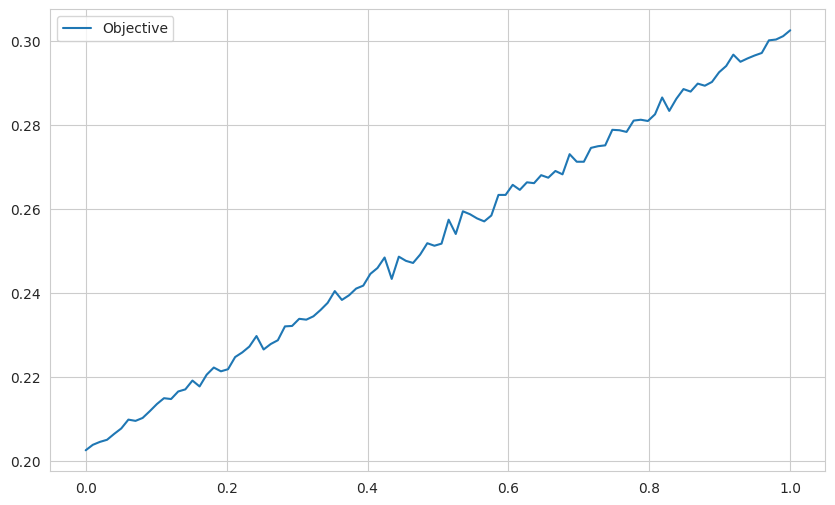

In [20]:
thetas = torch.linspace(0, 1, 100)
evals = 1000
objective = create_objective()

results = []
for theta in thetas:
    theta = torch.tensor([theta] * evals)
    betas = torch.bernoulli(theta)
    results.append(objective(betas).mean().item())

# plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=thetas.numpy(), y=results, label="Objective")

## Helpers for REBAR

In [21]:
def log_pb_bern(b, theta):
    """ Log probability of Bernoulli distribution. """
    return torch.log(theta) * b + torch.log(1 - theta) * (1 - b)

b = torch.tensor([1])
theta = torch.tensor([0.43], requires_grad=True)
log_pb_value = log_pb_bern(b, theta)

autograd.grad(log_pb_value, theta)

(tensor([2.3256]),)

In [22]:
def g(u, theta):
    """ 
    Differentiable reparametrization of z.

    Givem u ~ U(0, 1), and theta from (0, 1).
    Return a sample from p(z). Logistic distribution.
    """
    return torch.log(theta / (1 - theta)) + torch.log(u / (1 - u))


def g_tilde(v, b, theta):
    """
    Differentiable reparametrization of z|b.

    Given v ~ U(0, 1), b ~ Bernoulli(theta).
    and theta from (0, 1).

    Return a sample from the distribution p(z|b).
    """
    zb1 = torch.log((v / (1 - v)) * (1/(1-theta)) + 1)
    zb0 = -torch.log((v / (1 - v)) * (1/theta) + 1)
    return torch.where(b == 1, zb1, zb0)


def H(z):
    """
    The hard threshold function.
    """
    return torch.where(z >= 0, 1, 0)


def sigma(z, lmbda = 1):
    """
    Sigmoid with a temperature parameter.
    """
    return torch.sigmoid(z / lmbda)


def g_lmbda(u, theta, lmbda = 1):
    """
    Differentiable reparametrization of z_lmbda.

    After sigma this makes an alternative to sigma(g(u, theta), lmbda).
    lmbda must be the same for both g_lmbda and sigma.
    """
    quadratic = (lmbda**2 + lmbda + 1)/(lmbda + 1)
    z_lmbda = quadratic * torch.log(theta / (1 - theta)) + torch.log(u / (1 - u))
    return z_lmbda

## Manual SGD with fiex $\lambda$ and $\eta$

  7%|▋         | 343/5000 [00:00<00:05, 890.56it/s]


NaN detected


<Axes: >

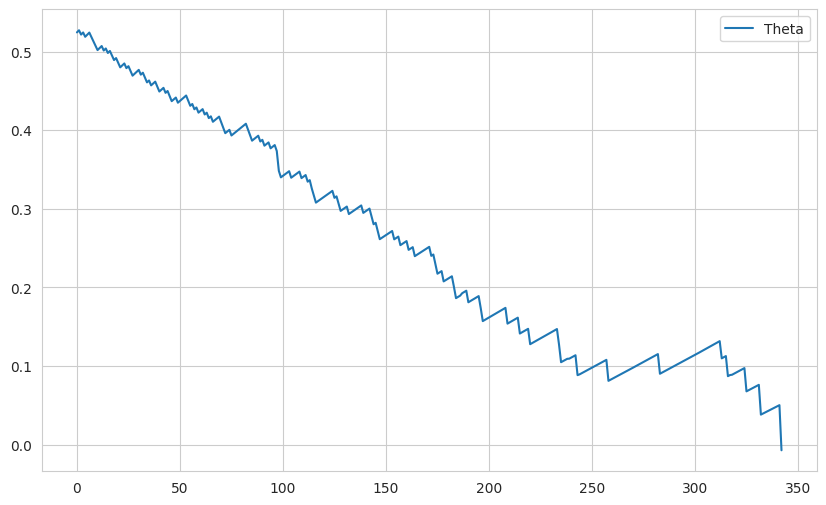

In [23]:
lmbda = 0.01
lr = 0.01
max_iter = 5000

n = 1
f = create_objective(target=0.4)
log_pb = log_pb_bern


thetas = []
estimates = []

eta = 0.2
theta = torch.tensor([0.53], requires_grad=True)

for _ in tqdm(range(max_iter)):

    estimate = torch.zeros(theta.shape)
    for _ in range(n):
        u, v = torch.rand(2, 1)
        z = g(u, theta)
        b = H(z).detach()
        z_tilde = g_tilde(v, b, theta)

        grad_log_pb = autograd.grad(log_pb(b, theta), theta)[0]
        first_term = ((f(b) - eta * f(sigma(z_tilde, lmbda))) * grad_log_pb).detach()
        second_term = eta * autograd.grad(f(sigma(z, lmbda)), theta)[0].detach()
        thrid_term = -eta * autograd.grad(f(sigma(z_tilde, lmbda)), theta)[0].detach()
        estimate += first_term + second_term + thrid_term

    estimate /= n

    if torch.isnan(estimate).any():
        print("NaN detected")
        break

    theta = (lr * (-estimate) + theta).detach() # SGD step
    # theta = torch.clamp(theta, 0.01, 0.99)
    thetas.append(theta.item())
    theta.requires_grad = True

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(thetas)), y=thetas, label="Theta")
sns.lineplot(x=range(len(estimates)), y=estimates, label="Estimate")

## Implementation with any torch optimizer

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:09<00:00, 546.44it/s]


<Axes: >

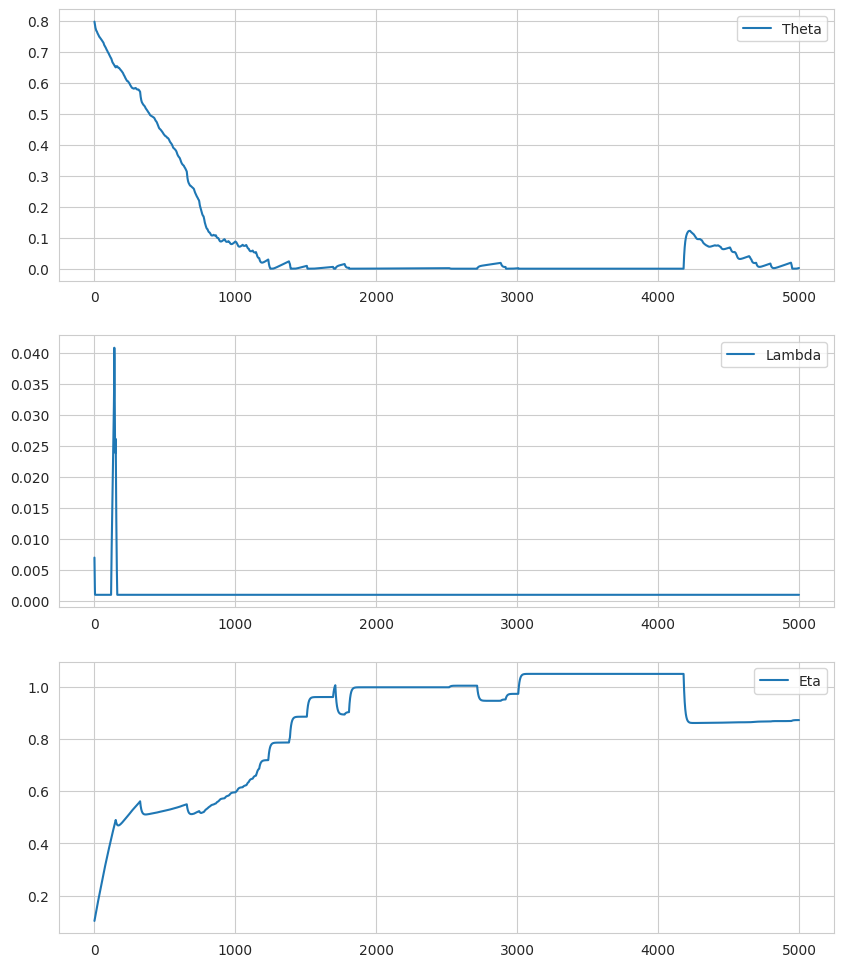

In [24]:
lr = 0.003
max_iter = 5000

n = 1
f = create_objective(target=0.4)
log_pb = log_pb_bern

lmbda = torch.tensor([0.01], requires_grad=True)
eta = torch.tensor([0.1], requires_grad=True)
theta = torch.tensor([0.8], requires_grad=True)

opt = torch.optim.Adam([theta, lmbda, eta], lr=lr, betas=(0.9, 0.99999))

thetas = []
lmbdas = []
etas = []
loss = []

for _ in tqdm(range(max_iter)):

    opt.zero_grad()

    loss = 0
    for _ in range(n):
        u, v = torch.rand(2, 1)

        z = g(u, theta)
        b = H(z).detach()
        z_tilde = g_tilde(v, b, theta)

        first_term = (f(b) - eta * f(sigma(z_tilde.detach(), lmbda))) * log_pb(b, theta)
        second_term = eta * f(sigma(z, lmbda))
        thrid_term = -eta * f(sigma(z_tilde, lmbda))
        loss += first_term + second_term + thrid_term

    loss /= n

    grad_estimate = autograd.grad(loss, theta, create_graph=True)[0]
    eta.grad, lmbda.grad = autograd.grad(torch.mean(grad_estimate ** 2), (eta, lmbda))
    theta.grad = grad_estimate.detach()

    # torch.nn.utils.clip_grad_norm_([theta, lmbda, eta], 100.0, norm_type="inf")

    opt.step()

    theta.data = torch.clamp(theta.data, 0.001, 0.999)
    lmbda.data = torch.clamp(lmbda.data, 0.001)

    if torch.isnan(theta).any():
        print("NaN detected")
        break

    thetas.append(theta.item())
    lmbdas.append(lmbda.item())
    etas.append(eta.item())

# Create a plot with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
sns.lineplot(x=range(len(thetas)), y=thetas, label="Theta", ax=axs[0])
sns.lineplot(x=range(len(lmbdas)), y=lmbdas, label="Lambda", ax=axs[1])
sns.lineplot(x=range(len(etas)), y=etas, label="Eta", ax=axs[2])


# Compare

In [25]:
lr = 0.003
max_iter = 5000
n = 1
target = 0.4
f = create_objective(target=target)
log_pb = log_pb_bern

SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

100%|██████████| 5000/5000 [00:07<00:00, 631.75it/s]


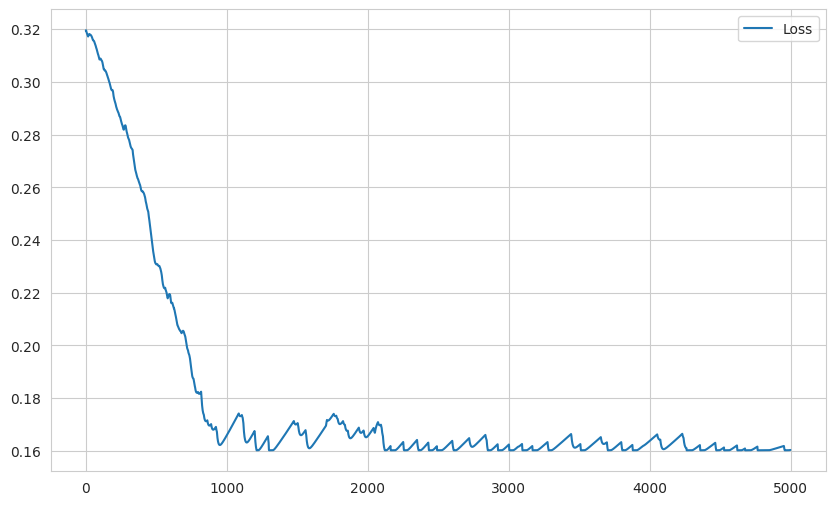

In [26]:
# REBAR
lmbda = torch.tensor([0.01], requires_grad=True)
eta = torch.tensor([0.1], requires_grad=True)
theta = torch.tensor([0.8], requires_grad=True)

opt = torch.optim.Adam([theta, lmbda, eta], lr=lr, betas=(0.9, 0.99999))
opt = torch.optim.Adam([theta], lr=lr, betas=(0.9, 0.99999))
# opt = torch.optim.SGD([theta, lmbda, eta], lr=lr)

thetas = []
lmbdas = []
etas = []
losses = []

for _ in tqdm(range(max_iter)):
    opt.zero_grad()
    
    loss = 0
    for _ in range(n):
        u, v = torch.rand(2, 1)
        z = g(u, theta)
        b = H(z).detach()
        z_tilde = g_tilde(v, b, theta)
        
        first_term = (f(b) - eta * f(sigma(z_tilde.detach(), lmbda))) * log_pb(b, theta)
        second_term = eta * f(sigma(z, lmbda))
        third_term = -eta * f(sigma(z_tilde, lmbda))
        loss += first_term + second_term + third_term
    
    loss /= n
    
    grad_estimate = autograd.grad(loss, theta, create_graph=True)[0]
    eta.grad, lmbda.grad = autograd.grad(torch.mean(grad_estimate ** 2), (eta, lmbda))
    theta.grad = grad_estimate.detach()
    
    opt.step()
    
    theta.data = torch.clamp(theta.data, 0.001, 0.999)
    lmbda.data = torch.clamp(lmbda.data, 0.001)
    
    if torch.isnan(theta).any():
        print("NaN detected")
        break
    
    thetas.append(theta.item())
    lmbdas.append(lmbda.item())
    etas.append(eta.item())
    theta_item = theta.item()
    exp_val = theta_item - 2*target*theta_item + target*target
    losses.append(exp_val)

losses_rebar = losses

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(losses)), y=losses, label="Loss")
plt.show()

100%|██████████| 5000/5000 [00:02<00:00, 1954.43it/s]


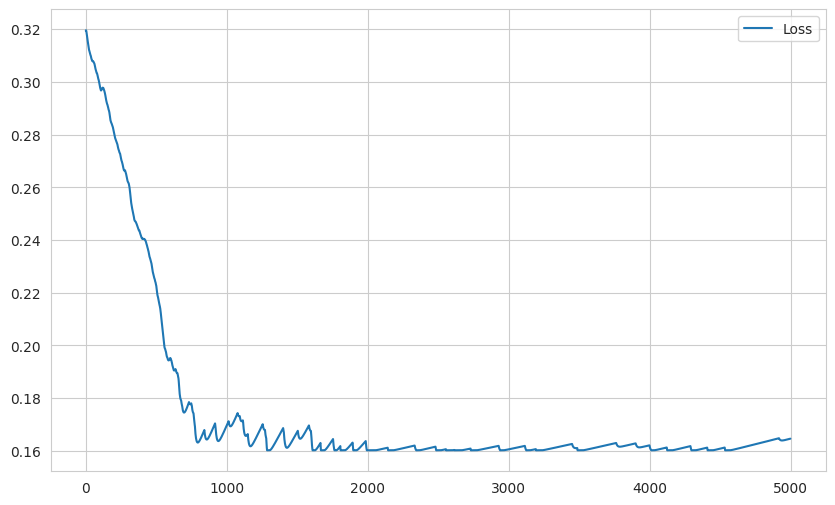

In [27]:
# REINFORCE

theta = torch.tensor([0.8], requires_grad=True)
opt = torch.optim.Adam([theta], lr=lr, betas=(0.9, 0.99999))

thetas = []
losses = []

for _ in tqdm(range(max_iter)):
    opt.zero_grad()
    
    loss = 0
    for _ in range(n):
        u, v = torch.rand(2, 1)
        z = g(u, theta)
        b = H(z).detach()
        
        loss += f(b) * log_pb(b, theta)
    
    loss /= n
    
    grad_estimate = autograd.grad(loss, theta, create_graph=False)[0]
    theta.grad = grad_estimate.detach()
    
    opt.step()
    
    theta.data = torch.clamp(theta.data, 0.001, 0.999)
    
    if torch.isnan(theta).any():
        print("NaN detected")
        break
    
    thetas.append(theta.item())
    theta_item = theta.item()
    exp_val = theta_item - 2*target*theta_item + target*target
    losses.append(exp_val)

losses_reinforce = losses

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(losses)), y=losses, label="Loss")
plt.show()

100%|██████████| 5000/5000 [00:02<00:00, 2179.40it/s]


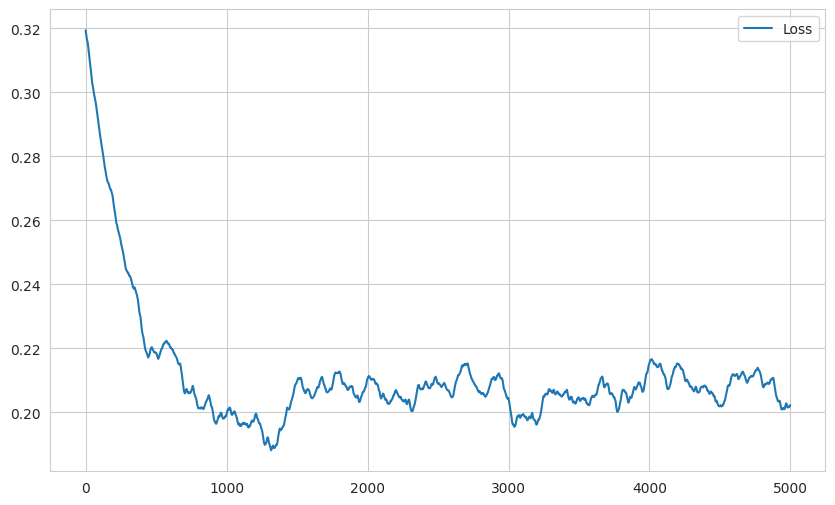

In [28]:
# CONCRETE

thetas = []
losses = []

eta = 0.2
lmbda = 0.5
theta = torch.tensor([0.8], requires_grad=True)

opt = torch.optim.Adam([theta], lr=lr, betas=(0.9, 0.99999))

for _ in tqdm(range(max_iter)):
    opt.zero_grad()
    
    loss = 0
    for _ in range(n):
        u = torch.rand(1)
        z = g(u, theta)
        loss += f(sigma(z, lmbda))
    
    loss /= n
    loss.backward()
    
    theta.grad = theta.grad.detach()
    opt.step()
    
    theta.data = torch.clamp(theta.data, 0.001, 0.999)
    
    if torch.isnan(theta).any():
        print("NaN detected")
        break
    
    thetas.append(theta.item())
    theta_item = theta.item()
    exp_val = theta_item - 2*target*theta_item + target*target
    losses.append(exp_val)

losses_concrete = losses

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(losses)), y=losses, label="Loss")
plt.show()

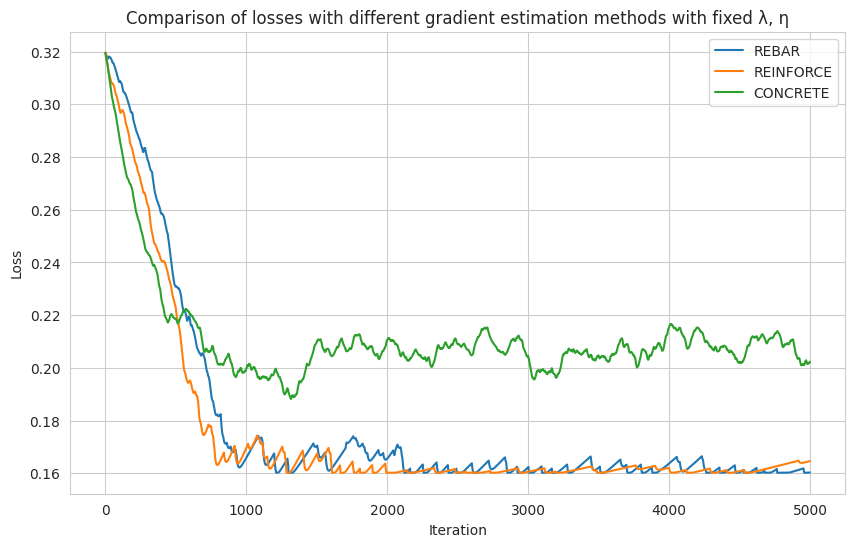

In [29]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=losses_rebar, label='REBAR')
sns.lineplot(data=losses_reinforce, label='REINFORCE')
sns.lineplot(data=losses_concrete, label='CONCRETE')

plt.legend()
# plt.title('Comparison of losses with different gradient estimation methods with learnable λ, η')
plt.title('Comparison of losses with different gradient estimation methods with fixed λ, η')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.savefig('toy_learnable_comparison.png')
plt.savefig('toy_fixed_comparison.png')
plt.show()

# Variance Comparison

In [67]:
lr = 0.003
max_iter = 5000
n = 1
n_experiments = 1000
target = 0.4
f = create_objective(target=target)
log_pb = log_pb_bern

SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

100%|██████████| 5000/5000 [1:14:13<00:00,  1.12it/s]


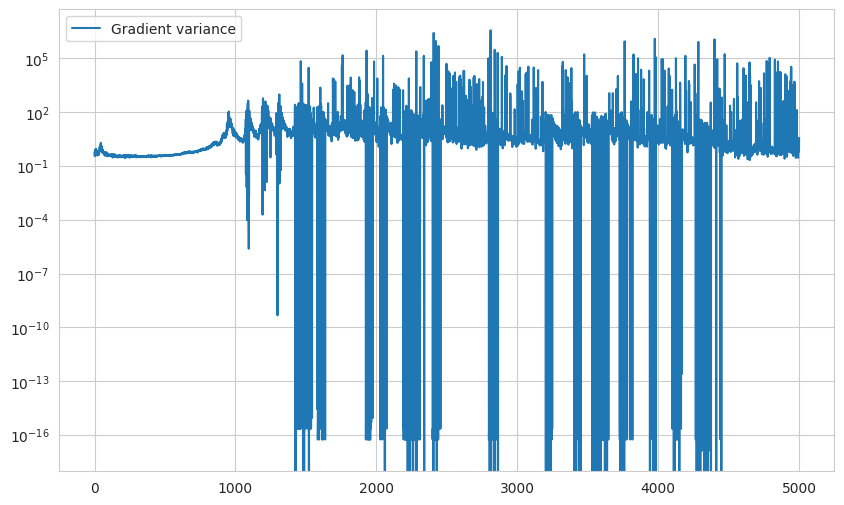

In [68]:
# Initialize parameters
lmbda = torch.tensor([0.01], requires_grad=True)
eta = torch.tensor([0.1], requires_grad=True)
theta = torch.tensor([0.8], requires_grad=True)

opt = torch.optim.Adam([theta, lmbda, eta], lr=lr, betas=(0.9, 0.99999))

thetas = []
lmbdas = []
etas = []
losses = []
variances = []

for _ in tqdm(range(max_iter)):
    opt.zero_grad()
    
    # Vectorized version for variance estimation
    u = torch.rand(n_experiments, 1)
    v = torch.rand(n_experiments, 1)
    
    # Compute all samples in parallel
    z = g(u, theta)
    b = H(z).detach()
    z_tilde = g_tilde(v, b, theta)
    
    # Compute all terms in parallel
    first_term = (f(b) - eta * f(sigma(z_tilde.detach(), lmbda))) * log_pb(b, theta)
    second_term = eta * f(sigma(z, lmbda))
    third_term = -eta * f(sigma(z_tilde, lmbda))
    batch_losses = (first_term + second_term + third_term) / n
    
    # Compute gradients for each sample in batch
    grad_estimates = []
    for i in range(n_experiments):
        grad = autograd.grad(batch_losses[i], theta, create_graph=True)[0].detach()
        grad_estimates.append(grad)
    
    variances.append(torch.stack(grad_estimates).var().item())

    # Original optimization step (could also be vectorized further)
    loss = 0
    for _ in range(n):
        u, v = torch.rand(2, 1)
        z = g(u, theta)
        b = H(z).detach()
        z_tilde = g_tilde(v, b, theta)
        
        first_term = (f(b) - eta * f(sigma(z_tilde.detach(), lmbda))) * log_pb(b, theta)
        second_term = eta * f(sigma(z, lmbda))
        third_term = -eta * f(sigma(z_tilde, lmbda))
        loss += first_term + second_term + third_term
    
    loss /= n
    
    grad_estimate = autograd.grad(loss, theta, create_graph=True)[0]
    eta.grad, lmbda.grad = autograd.grad(torch.mean(grad_estimate ** 2), (eta, lmbda))
    theta.grad = grad_estimate.detach()
    
    opt.step()
    
    theta.data = torch.clamp(theta.data, 0.001, 0.999)
    lmbda.data = torch.clamp(lmbda.data, 0.001)
    
    if torch.isnan(theta).any():
        print("NaN detected")
        break
    
    thetas.append(theta.item())
    lmbdas.append(lmbda.item())
    etas.append(eta.item())
    theta_item = theta.item()
    exp_val = theta_item - 2*target*theta_item + target*target
    losses.append(exp_val)

losses_rebar = losses

variances_rebar = variances

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(variances)), y=variances, label="Gradient variance")
plt.yscale('log')
plt.show()

100%|██████████| 5000/5000 [33:03<00:00,  2.52it/s]


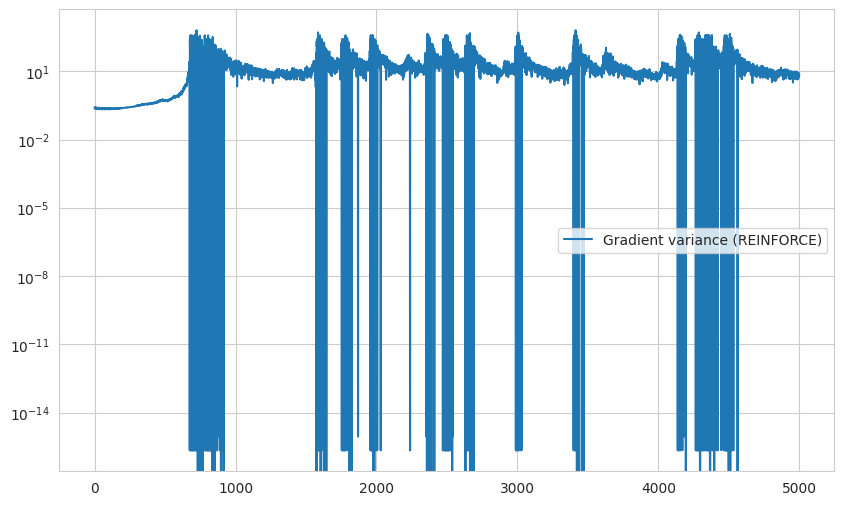

In [69]:
# Initialize parameters
theta = torch.tensor([0.8], requires_grad=True)
opt = torch.optim.Adam([theta], lr=lr, betas=(0.9, 0.99999))

thetas = []
losses = []
variances = []

for _ in tqdm(range(max_iter)):
    opt.zero_grad()
    
    # Vectorized variance estimation
    grad_estimates = []
    for _ in range(n_experiments):
        u = torch.rand(n, 1)
        z = g(u, theta)
        b = H(z).detach()
        loss = torch.mean(f(b) * log_pb(b, theta))
        grad = autograd.grad(loss, theta, create_graph=False)[0].detach()
        grad_estimates.append(grad)
    
    variances.append(torch.stack(grad_estimates).var().item())

    # Actual loss for gradient update
    u = torch.rand(n, 1)
    z = g(u, theta)
    b = H(z).detach()
    loss = torch.mean(f(b) * log_pb(b, theta))

    grad_estimate = autograd.grad(loss, theta, create_graph=False)[0]
    theta.grad = grad_estimate.detach()

    opt.step()
    theta.data = torch.clamp(theta.data, 0.001, 0.999)

    if torch.isnan(theta).any():
        print("NaN detected")
        break

    thetas.append(theta.item())
    theta_item = theta.item()
    exp_val = theta_item - 2 * target * theta_item + target * target
    losses.append(exp_val)

losses_reinforce = losses
variances_reinforce = variances

# Plot variance (log scale)
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(variances)), y=variances, label="Gradient variance (REINFORCE)")
plt.yscale('log')
plt.show()


100%|██████████| 5000/5000 [25:11<00:00,  3.31it/s]


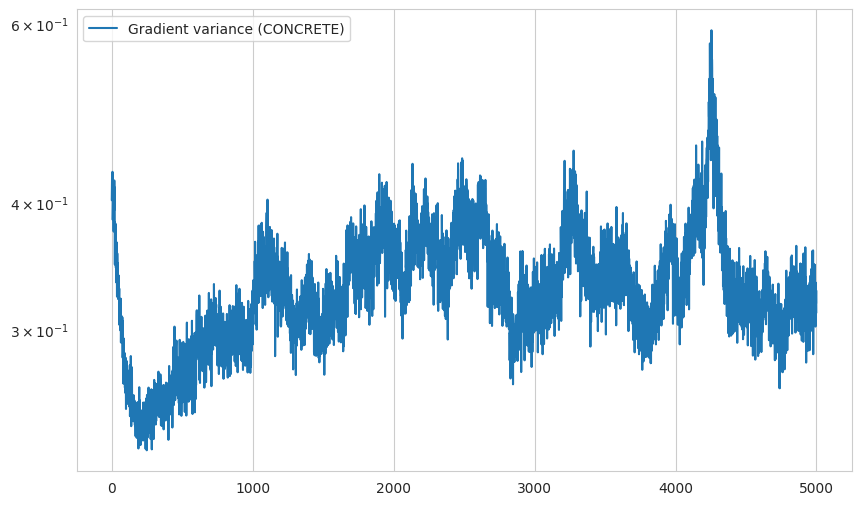

In [70]:
# Initialize parameters
eta = 0.2
lmbda = 0.5
theta = torch.tensor([0.8], requires_grad=True)

opt = torch.optim.Adam([theta], lr=lr, betas=(0.9, 0.99999))

thetas = []
losses = []
variances = []

for _ in tqdm(range(max_iter)):
    opt.zero_grad()

    # Vectorized variance estimation
    '''
    grad_estimates = []
    u = torch.rand(n_experiments, n, 1)
    z = g(u, theta)
    sigma_z = sigma(z, lmbda)
    f_sigma = f(sigma_z)
    batch_losses = torch.mean(f_sigma, dim=1)

    for i in range(n_experiments):
        grad = autograd.grad(batch_losses[i], theta, create_graph=False)[0].detach()
        grad_estimates.append(grad)
    '''
    # Vectorized sampling per experiment, but independent computation
    grad_estimates = []
    for _ in range(n_experiments):
        u = torch.rand(n, 1)
        z = g(u, theta)
        sigma_z = sigma(z, lmbda)
        loss = torch.mean(f(sigma_z))
        grad = autograd.grad(loss, theta, create_graph=False)[0].detach()
        grad_estimates.append(grad)


    variances.append(torch.stack(grad_estimates).var().item())

    # Actual gradient update
    u = torch.rand(n, 1)
    z = g(u, theta)
    sigma_z = sigma(z, lmbda)
    loss = torch.mean(f(sigma_z))

    loss.backward()
    theta.grad = theta.grad.detach()
    opt.step()

    theta.data = torch.clamp(theta.data, 0.001, 0.999)

    if torch.isnan(theta).any():
        print("NaN detected")
        break

    thetas.append(theta.item())
    theta_item = theta.item()
    exp_val = theta_item - 2 * target * theta_item + target * target
    losses.append(exp_val)

losses_concrete = losses
variances_concrete = variances

# Plot gradient variance (log scale)
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(variances)), y=variances, label="Gradient variance (CONCRETE)")
plt.yscale('log')
plt.show()


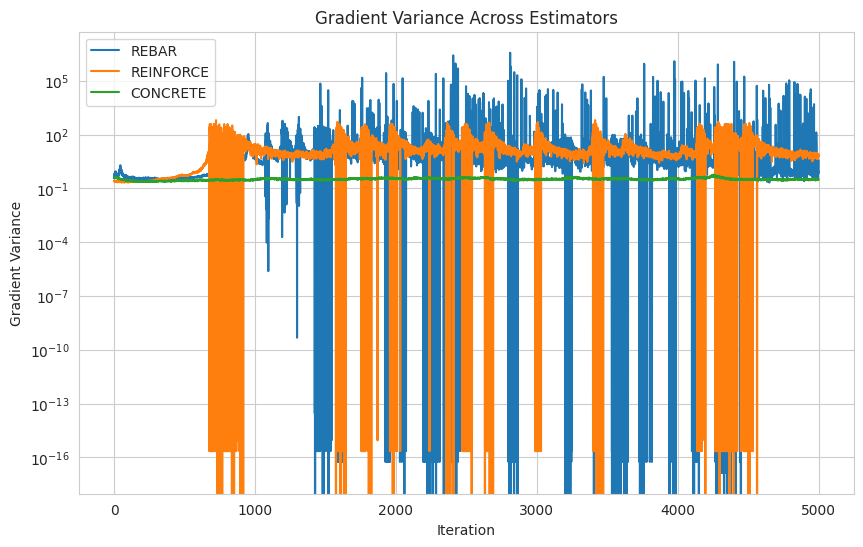

In [71]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=variances_rebar, label='REBAR')
sns.lineplot(data=variances_reinforce, label='REINFORCE')
sns.lineplot(data=variances_concrete, label='CONCRETE')

plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Gradient Variance')
plt.yscale('log')
plt.title('Gradient Variance Across Estimators')
plt.show()

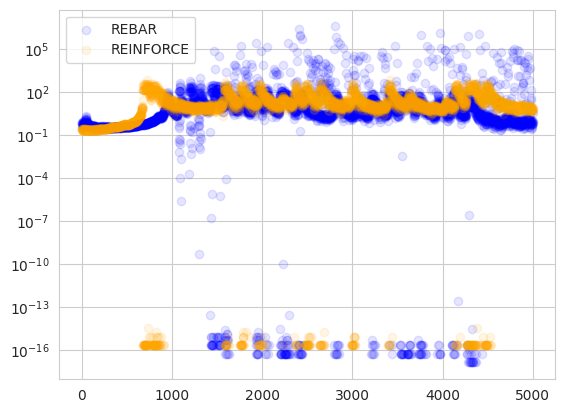

In [74]:
plt.scatter(range(len(variances_rebar)), variances_rebar, color='blue', alpha=0.1)
plt.scatter(range(len(variances_reinforce)), variances_reinforce, color='orange', alpha=0.1)
plt.legend(['REBAR', 'REINFORCE'])
plt.yscale('log')

## Implementation with quadratic relaxation from Appendix E

100%|██████████| 5000/5000 [00:08<00:00, 577.16it/s]


<Axes: >

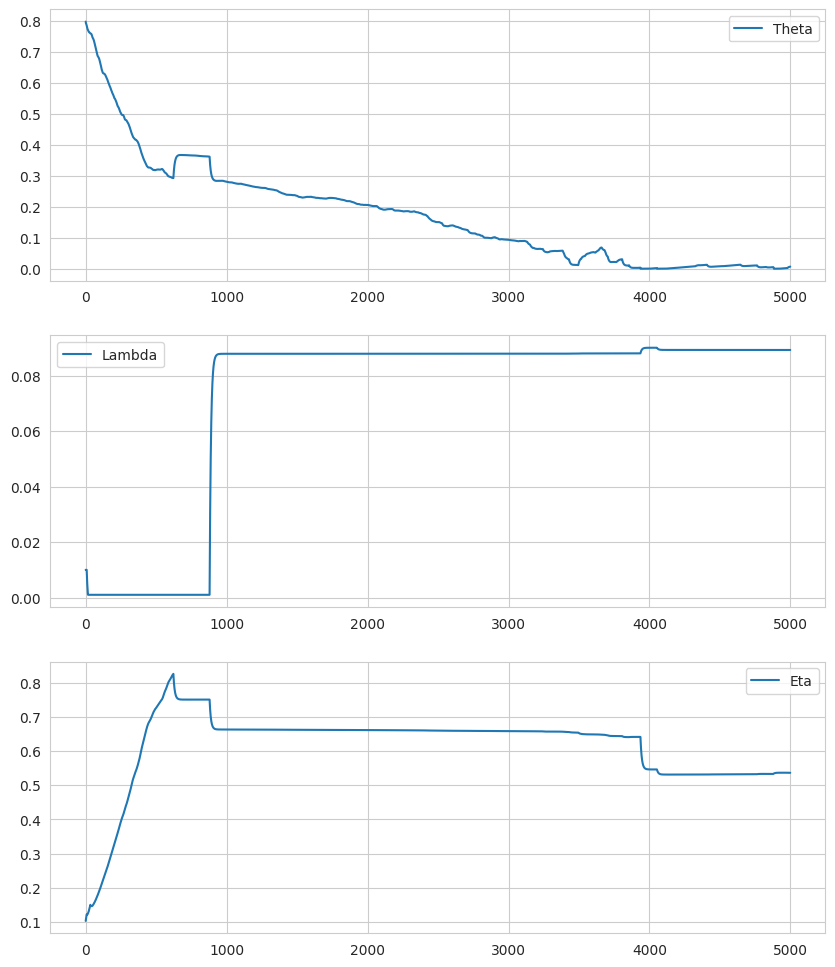

In [8]:
lr = 0.003
max_iter = 5000

n = 1
f = create_objective(target=0.4)
log_pb = log_pb_bern

lmbda = torch.tensor([0.01], requires_grad=True)
eta = torch.tensor([0.1], requires_grad=True)
theta = torch.tensor([0.8], requires_grad=True)

opt = torch.optim.Adam([theta, lmbda, eta], lr=lr, betas=(0.9, 0.99999))

thetas = []
lmbdas = []
etas = []

for _ in tqdm(range(max_iter)):

    opt.zero_grad()

    loss = 0
    for _ in range(n):
        u, v = torch.rand(2, 1)

        z_lmbda = g_lmbda(u, theta, lmbda)
        b = H(z_lmbda).detach()
        z_tilde = g_tilde(v, b, theta)

        first_term = (f(b) - eta * f(sigma(z_tilde.detach(), lmbda))) * log_pb(b, theta)
        second_term = eta * f(sigma(z_lmbda, lmbda))
        thrid_term = -eta * f(sigma(z_tilde, lmbda))
        loss += first_term + second_term + thrid_term

    loss /= n

    grad_estimate = autograd.grad(loss, theta, create_graph=True)[0]
    eta.grad, lmbda.grad = autograd.grad(torch.mean(grad_estimate ** 2), (eta, lmbda))
    theta.grad = grad_estimate.detach()

    # torch.nn.utils.clip_grad_norm_([theta, lmbda, eta], 100.0, norm_type="inf")

    opt.step()

    theta.data = torch.clamp(theta.data, 0.001, 0.999)
    lmbda.data = torch.clamp(lmbda.data, 0.001)

    if torch.isnan(theta).any():
        print("NaN detected")
        break

    thetas.append(theta.item())
    lmbdas.append(lmbda.item())
    etas.append(eta.item())

# Create a plot with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
sns.lineplot(x=range(len(thetas)), y=thetas, label="Theta", ax=axs[0])
sns.lineplot(x=range(len(lmbdas)), y=lmbdas, label="Lambda", ax=axs[1])
sns.lineplot(x=range(len(etas)), y=etas, label="Eta", ax=axs[2])